<a href="https://www.kaggle.com/code/upamanyu179/voice-recognistion-project?scriptVersionId=221938531" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Live vs Electronic voice project

In [1]:
!pip install librosa soundfile

import os
import librosa
import soundfile as sf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Loading Data

In [2]:
# # Load audio files and extract features
# def extract_features(file_path):
#   audio, sample_rate = librosa.load(file_path, sr=None)
#   mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
#   return np.mean(mfccs.T, axis=0)


# # Load real and fake audio samples (replace with your actual file paths)
# # Define the paths for real and fake audio files for training
real_audio_path_train = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real'
fake_audio_path_train = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/fake'

real_audio_path_test = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/real'
fake_audio_path_test = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/fake'

real_audio_path_val = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/real'
fake_audio_path_val = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/fake'


# Gather all the .wav files from the directories
#training
real_audio_files_train = [os.path.join(real_audio_path_train, file) for file in os.listdir(real_audio_path_train) if file.endswith('.wav')]
fake_audio_files_train = [os.path.join(fake_audio_path_train, file) for file in os.listdir(fake_audio_path_train) if file.endswith('.wav')]

#testing
real_audio_files_test = [os.path.join(real_audio_path_test, file) for file in os.listdir(real_audio_path_test) if file.endswith('.wav')]
fake_audio_files_test = [os.path.join(fake_audio_path_test, file) for file in os.listdir(fake_audio_path_test) if file.endswith('.wav')]

#validation
real_audio_files_val = [os.path.join(real_audio_path_val, file) for file in os.listdir(real_audio_path_val) if file.endswith('.wav')]
fake_audio_files_val = [os.path.join(fake_audio_path_val, file) for file in os.listdir(fake_audio_path_val) if file.endswith('.wav')]

## Data Preprocessing

In [3]:
def extract_top_energy_frames(audio, sample_rate, n_frames=10, low_freq_limit=40):
    # Apply STFT
    stft_result = np.abs(librosa.stft(audio))
    
    # Compute Low-Frequency Average Energy
    low_freq_bins = librosa.fft_frequencies(sr=sample_rate) < low_freq_limit
    low_freq_energy = np.mean(stft_result[low_freq_bins, :], axis=0)
    
    # Select top n_frames based on energy
    top_frames_idx = np.argsort(low_freq_energy)[-n_frames:]
    selected_frames = stft_result[:, top_frames_idx]
    
    return selected_frames  # Shape (n_freq_bins, n_frames)



In [4]:
!pip install gammatone

In [5]:
from gammatone.filters import make_erb_filters, erb_filterbank
from scipy.fftpack import dct

def calculate_gfcc(audio, sample_rate, n_filters=13):
    # Create ERB filters
    erb_filter = make_erb_filters(sample_rate, n_filters)
    
    # Apply Gammatone filterbank to each frame
    gfcc_list = []
    for frame in audio.T:  # Iterate over each frame (time axis)
        gammatone_out = erb_filterbank(frame, erb_filter)
        # Apply DCT and store result
        gfcc = dct(np.log(np.abs(gammatone_out) + 1e-6), axis=0, type=2, norm='ortho')
        gfcc_list.append(gfcc)
    
    # Convert list to np.array of shape (n_filters, n_frames)
    return np.array(gfcc_list).T  # Transpose to match shape (n_frames, n_filters)


In [6]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    
    # Step 1: Select Top Energy Frames with STFT + LFAE
    selected_frames = extract_top_energy_frames(audio, sample_rate)

    # Step 2: GFCC Calculation for selected frames
    gfccs = calculate_gfcc(selected_frames, sample_rate)

    # Mean GFCCs as final feature vector
    return np.mean(gfccs, axis=1)


In [7]:
# Extract features and create labels for training
X_train = []
y_train = []
for file in real_audio_files_train:
  X_train.append(extract_features(file))
  y_train.append(0)  # Label 0 for real audio

for file in fake_audio_files_train:
  X_train.append(extract_features(file))
  y_train.append(1)  # Label 1 for fake audio



In [8]:
# Extract features and create labels for testing
X_test = []
y_test = []
for file in real_audio_files_test:
  X_test.append(extract_features(file))
  y_test.append(0)  # Label 0 for real audio

for file in fake_audio_files_test:
  X_test.append(extract_features(file))
  y_test.append(1)  # Label 1 for fake audio

In [9]:
# Extract features and create labels for validation
X_val = []
y_val = []
for file in real_audio_files_val:
  X_val.append(extract_features(file))
  y_val.append(0)  # Label 0 for real audio

for file in fake_audio_files_val:
  X_val.append(extract_features(file))
  y_val.append(1)  # Label 1 for fake audio

### Features after preprocessing

#### 1. Visualize Raw Audio Data (Before Preprocessing)

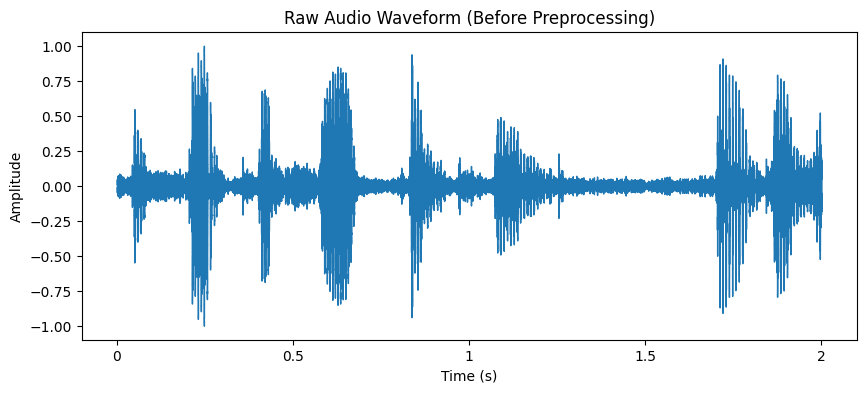

In [10]:
import librosa.display
import matplotlib.pyplot as plt

# Load a sample real audio file (change the file path as needed)
sample_file = real_audio_files_train[0]  # Replace with a file from your dataset
audio, sample_rate = librosa.load(sample_file, sr=None)

# Plot raw waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate)
plt.title("Raw Audio Waveform (Before Preprocessing)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


#### 2. Visualize STFT Spectrogram (During Preprocessing)

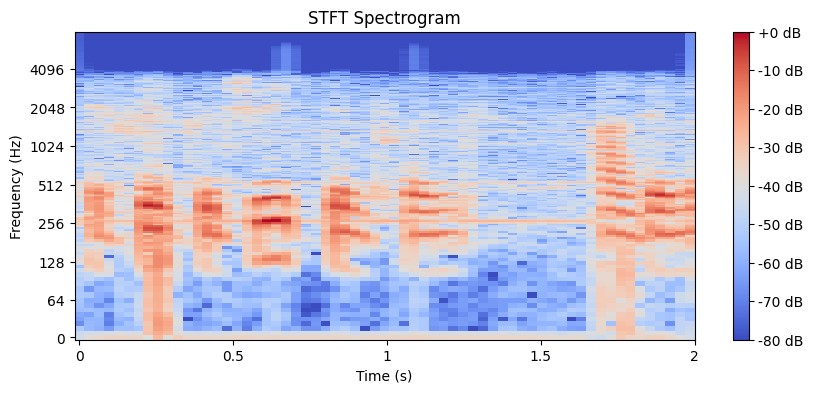

In [11]:
# Compute STFT
stft_result = np.abs(librosa.stft(audio))
stft_db = librosa.amplitude_to_db(stft_result, ref=np.max)

# Plot STFT spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(stft_db, sr=sample_rate, x_axis='time', y_axis='log', cmap='coolwarm')
plt.title("STFT Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

#### 3. Visualize Selected Frames After LFAE (Low-Frequency Average Energy)

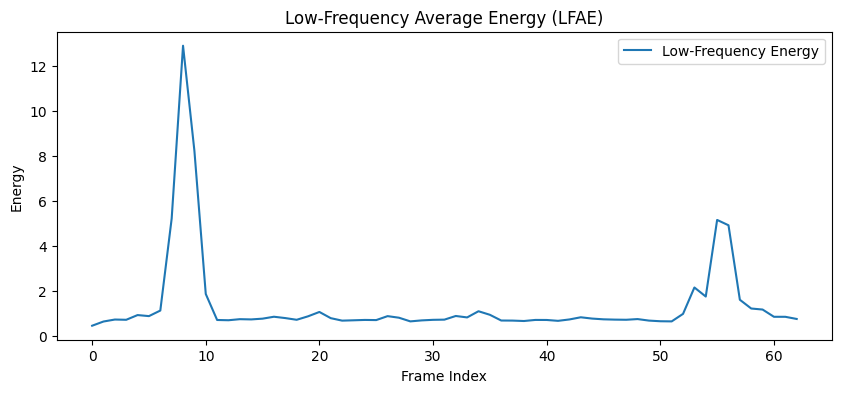

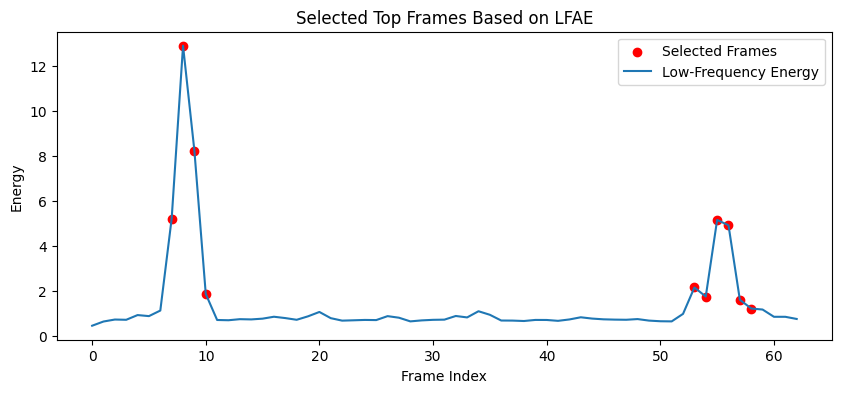

In [12]:
# Compute low-frequency energy
stft_result = np.abs(librosa.stft(audio))
low_freq_bins = librosa.fft_frequencies(sr=sample_rate) < 40
low_freq_energy = np.mean(stft_result[low_freq_bins, :], axis=0)

# Plot low-frequency energy
plt.figure(figsize=(10, 4))
plt.plot(low_freq_energy, label="Low-Frequency Energy")
plt.title("Low-Frequency Average Energy (LFAE)")
plt.xlabel("Frame Index")
plt.ylabel("Energy")
plt.legend()
plt.show()

# Highlight selected frames
top_frames_idx = np.argsort(low_freq_energy)[-10:]
plt.figure(figsize=(10, 4))
plt.scatter(top_frames_idx, low_freq_energy[top_frames_idx], color='red', label="Selected Frames")
plt.plot(low_freq_energy, label="Low-Frequency Energy")
plt.title("Selected Top Frames Based on LFAE")
plt.xlabel("Frame Index")
plt.ylabel("Energy")
plt.legend()
plt.show()

#### 4. Visualize GFCC Features (After Preprocessing)

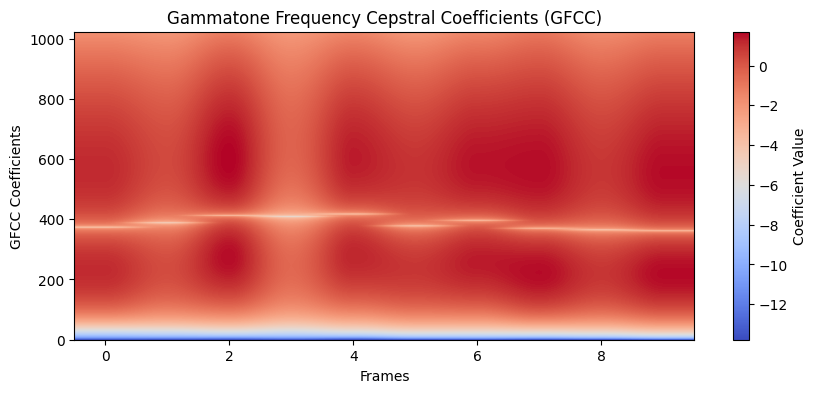

In [13]:
# Ensure the GFCC features have the correct shape (2D array)
selected_frames = extract_top_energy_frames(audio, sample_rate)
gfcc_features = calculate_gfcc(selected_frames, sample_rate)
gfcc_features_squeezed = np.squeeze(gfcc_features)  # Remove singleton dimension

# Plot GFCC features
plt.figure(figsize=(10, 4))
plt.imshow(gfcc_features_squeezed, aspect='auto', origin='lower', cmap='coolwarm')
plt.title("Gammatone Frequency Cepstral Coefficients (GFCC)")
plt.colorbar(label="Coefficient Value")
plt.xlabel("Frames")
plt.ylabel("GFCC Coefficients")
plt.show()


#### 5. Visualize Preprocessed Feature Vectors

GFCC Features Shape After Squeeze: (1025, 10)
Feature Vector Shape After Mean: (1025,)


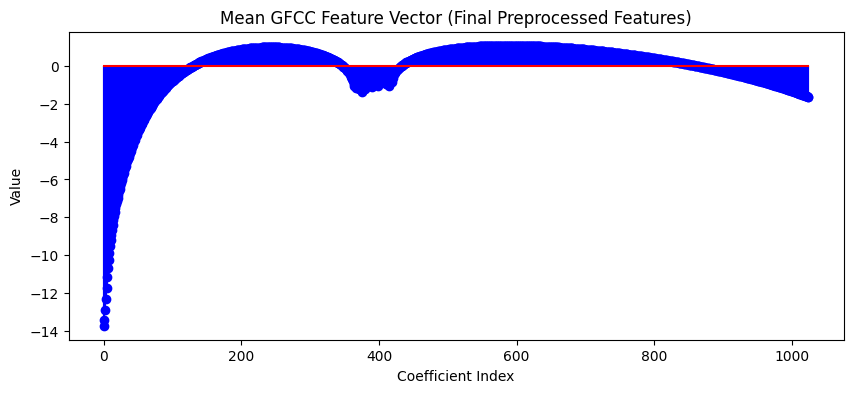

In [14]:
# Ensure the GFCC features have the correct shape
gfcc_features_squeezed = np.squeeze(gfcc_features)  # Remove singleton dimension
print("GFCC Features Shape After Squeeze:", gfcc_features_squeezed.shape)

# Compute mean GFCC feature vector across frames
feature_vector = np.mean(gfcc_features_squeezed, axis=1)  # Mean across frames (axis=1)
print("Feature Vector Shape After Mean:", feature_vector.shape)

# Plot feature vector
plt.figure(figsize=(10, 4))
plt.stem(feature_vector, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title("Mean GFCC Feature Vector (Final Preprocessed Features)")
plt.xlabel("Coefficient Index")
plt.ylabel("Value")
plt.show()


## Model Architecture

In [15]:
!pip install tensorflow keras


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Pre-Activation Residual Block
def preact_res_block(inputs, filters, kernel_size=3, strides=1):
    """
    Pre-activation Residual Block
    """
    x = layers.BatchNormalization()(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)

    # Shortcut connection
    shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(inputs)
    return layers.add([x, shortcut])

In [17]:
# Self-Attentional Pooling Layer
class SelfAttentionalPooling(layers.Layer):
    def __init__(self):
        super(SelfAttentionalPooling, self).__init__()

    def call(self, inputs):
        """
        Self-Attention Pooling: Assign weights to input frames.
        inputs: (batch_size, n_frames, n_features)
        """
        attention_scores = tf.nn.softmax(inputs, axis=1)  # Softmax over time frames
        weighted_inputs = inputs * attention_scores
        return tf.reduce_sum(weighted_inputs, axis=1)  # Weighted sum over time frames



In [18]:
# ResNet with Self-Attentional Pooling
def create_self_attention_resnet(input_shape):
    """
    Create Self-Attentional ResNet model.
    """
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks
    x = preact_res_block(x, filters=64)
    x = preact_res_block(x, filters=128, strides=2)
    x = preact_res_block(x, filters=256, strides=2)
    x = preact_res_block(x, filters=512, strides=2)

    # Global Average Pooling (Flatten Features)
    x = layers.GlobalAveragePooling2D()(x)

    # Self-Attentional Pooling
    x = layers.Reshape((1, -1))(x)  # Reshape to (batch_size, n_frames, n_features)
    x = SelfAttentionalPooling()(x)

    # Fully Connected Layers for Output
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

    # Create Model
    model = models.Model(inputs, outputs)
    return model

In [19]:
print(f"Shape of a single feature: {np.array(X_train[0]).shape}")

Shape of a single feature: (1025, 10)


In [20]:
n_frames_train, n_features_train = np.array(X_train[0]).shape
print(f"Number of frames: {n_frames_train}, Number of features: {n_features_train}")

Number of frames: 1025, Number of features: 10


In [21]:
n_frames_train

1025

In [22]:
n_frames_test, n_features_test = np.array(X_test[0]).shape
print(f"Number of frames: {n_frames_test}, Number of features: {n_features_test}")

Number of frames: 1025, Number of features: 10


In [23]:
n_frames_val, n_features_val = np.array(X_val[0]).shape
print(f"Number of frames: {n_frames_val}, Number of features: {n_features_val}")

Number of frames: 1025, Number of features: 10


In [24]:
# Reshape GFCC features for ResNet input
X_train = np.array(X_train).reshape(-1, n_frames_train, n_features_train, 1)
X_val = np.array(X_val).reshape(-1, n_frames_test, n_features_test, 1)
X_test = np.array(X_test).reshape(-1, n_frames_val, n_features_val, 1)

# Ensure labels are numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (13956, 1025, 10, 1)
X_val shape: (2826, 1025, 10, 1)
X_test shape: (1088, 1025, 10, 1)


## Model Training

In [25]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import os

# Filepath to save the model
model_file = "self_attention_resnet_model.h5"

if not os.path.exists(model_file):
    # Reduce learning rate scheduler
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0003 * 0.5 ** (epoch // 3))

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Create and compile the model
    input_shape = (n_frames_train, n_features_train, 1)  # Update based on your GFCC dimensions
    model = create_self_attention_resnet(input_shape)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model with early stopping and learning rate scheduler
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=20,  # Increase epochs if necessary
                        batch_size=32,  # Experiment with different batch sizes
                        callbacks=[early_stopping, lr_scheduler])

    # Save the trained model
    model.save(model_file)
    print("Model saved!")
else:
    # Load the saved model
    model = tf.keras.models.load_model(model_file)
    print("Model loaded!")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 430s 961ms/step - accuracy: 0.6326 - loss: 0.6788 - val_accuracy: 0.6550 - val_loss: 0.6976 - learning_rate: 3.0000e-04
Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 412s 943ms/step - accuracy: 0.6850 - loss: 0.6030 - val_accuracy: 0.7410 - val_loss: 0.5338 - learning_rate: 3.0000e-04
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 412s 944ms/step - accuracy: 0.7429 - loss: 0.5285 - val_accuracy: 0.7091 - val_loss: 0.6256 - learning_rate: 3.0000e-04
Epoch 4/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 444s 948ms/step - accuracy: 0.7980 - loss: 0.4429 - val_accuracy: 0.8192 - val_loss: 0.4007 - learning_rate: 1.5000e-04
Epoch 5/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 417s 954ms/step - accuracy: 0.8226 - loss: 0.3961 - val_accuracy: 0.7236 - val_loss: 0.7136 - learning_rate: 1.5000e-04
Epoch 6/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.8504 - loss: 0.3410 - val_accuracy: 0.7955 - val_loss: 0.4490 - learning_rate: 1.5000e-04
Epoch 7/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 422

### LightGBM

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Identify the correct output layer for feature extraction
# Ensure the layer name is correct. You can verify it using `model.summary()`.
feature_extraction_layer = model.get_layer(index=-2).output  # Second-to-last layer (before final Dense)

# Create feature extractor model
feature_extractor = Model(inputs=model.input, outputs=feature_extraction_layer)

# Extract features for train, validation, and test sets
X_train_features = feature_extractor.predict(X_train, batch_size=32)
X_val_features = feature_extractor.predict(X_val, batch_size=32)
X_test_features = feature_extractor.predict(X_test, batch_size=32)

# Ensure labels are numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# 2. Train LightGBM Classifier
# LightGBM Dataset
train_data = lgb.Dataset(X_train_features, label=y_train)
val_data = lgb.Dataset(X_val_features, label=y_val, reference=train_data)

# LightGBM Parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
lightgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# 3. Evaluate LightGBM on Test Set
y_pred = lightgbm_model.predict(X_test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy and Classification Report
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

437/437 ━━━━━━━━━━━━━━━━━━━━ 96s 218ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step
[LightGBM] [Info] Number of positive: 6978, number of negative: 6978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 13956, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's binary_error: 0.0319576	valid_1's binary_error: 0.0746638
Test Accuracy: 71.97%
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       544
           1       0.71      0.75      0.73       544

    accuracy                           0.72      1088

### Resnet

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



# Define optimizer and learning rate schedule
optimizer = Adam(learning_rate=0.0003)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1, 
    min_lr=1e-6
)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    verbose=1, 
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the ResNet model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    batch_size=32, 
    epochs=15, 
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)


Epoch 1/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 425s 953ms/step - accuracy: 0.8746 - loss: 0.3047 - val_accuracy: 0.6812 - val_loss: 0.8852 - learning_rate: 3.0000e-04
Epoch 2/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 425s 972ms/step - accuracy: 0.8764 - loss: 0.2959 - val_accuracy: 0.8970 - val_loss: 0.2538 - learning_rate: 3.0000e-04
Epoch 3/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 417s 953ms/step - accuracy: 0.8845 - loss: 0.2689 - val_accuracy: 0.7767 - val_loss: 0.4863 - learning_rate: 3.0000e-04
Epoch 4/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 420s 961ms/step - accuracy: 0.8932 - loss: 0.2631 - val_accuracy: 0.7413 - val_loss: 0.5460 - learning_rate: 3.0000e-04
Epoch 5/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 418s 956ms/step - accuracy: 0.8969 - loss: 0.2446 - val_accuracy: 0.8248 - val_loss: 0.3620 - learning_rate: 3.0000e-04
Epoch 6/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 423s 968ms/step - accuracy: 0.8967 - loss: 0.2470 - val_accuracy: 0.7127 - val_loss: 0.7230 - learning_rate: 3.0000e-04
Epoch 7/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 

## Testing

In [28]:
# Extract features for LightGBM
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)
X_test_features = feature_extractor.predict(X_test)


437/437 ━━━━━━━━━━━━━━━━━━━━ 94s 215ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step


### Resnet

In [29]:
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix
import numpy as np

# Predict probabilities on the test set
y_pred_probs_resnet = model.predict(X_test, batch_size=32)
y_pred_binary_resnet = (y_pred_probs_resnet > 0.5).astype(int)

# Calculate Accuracy
accuracy_resnet = accuracy_score(y_test, y_pred_binary_resnet)
print(f"ResNet Test Accuracy: {((accuracy_resnet * 100)):.2f}%")

# Calculate FAR/FRR and EER
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_resnet)
eer_threshold = thresholds[np.nanargmin(np.absolute(fpr - (1 - tpr)))]  # Find EER threshold
eer = fpr[np.nanargmin(np.absolute(fpr - (1 - tpr)))]  # Equal Error Rate

# Calculate FAR and FRR at EER
far = fpr[np.nanargmin(np.absolute(fpr - (1 - tpr)))]  # False Acceptance Rate
frr = 1 - tpr[np.nanargmin(np.absolute(fpr - (1 - tpr)))]  # False Rejection Rate

print(f"ResNet EER: {eer * 100:.2f}%")
print(f"ResNet FAR at EER: {far * 100:.2f}%")
print(f"ResNet FRR at EER: {frr * 100:.2f}%")


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step
ResNet Test Accuracy: 73.16%
ResNet EER: 24.26%
ResNet FAR at EER: 24.26%
ResNet FRR at EER: 24.26%


### LightGBM

In [30]:
from sklearn.metrics import roc_curve

# Predict probabilities on the test set
y_pred_probs_lgbm = lightgbm_model.predict(X_test_features)
y_pred_binary_lgbm = (y_pred_probs_lgbm > 0.5).astype(int)

# Calculate Accuracy
accuracy_lgbm = accuracy_score(y_test, y_pred_binary_lgbm)
print(f"LightGBM Test Accuracy: {accuracy_lgbm * 100:.2f}%")

# Calculate FAR/FRR and EER
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_lgbm)
eer_threshold = thresholds[np.nanargmin(np.absolute(fpr - (1 - tpr)))]  # Find EER threshold
eer = fpr[np.nanargmin(np.absolute(fpr - (1 - tpr)))]  # Equal Error Rate

# Calculate FAR and FRR at EER
far = fpr[np.nanargmin(np.absolute(fpr - (1 - tpr)))]  # False Acceptance Rate
frr = 1 - tpr[np.nanargmin(np.absolute(fpr - (1 - tpr)))]  # False Rejection Rate

print(f"LightGBM EER: {eer * 100:.2f}%")
print(f"LightGBM FAR at EER: {far * 100:.2f}%")
print(f"LightGBM FRR at EER: {frr * 100:.2f}%")


LightGBM Test Accuracy: 71.78%
LightGBM EER: 28.12%
LightGBM FAR at EER: 28.12%
LightGBM FRR at EER: 27.21%


## Evaluation

ResNet Confusion Matrix:


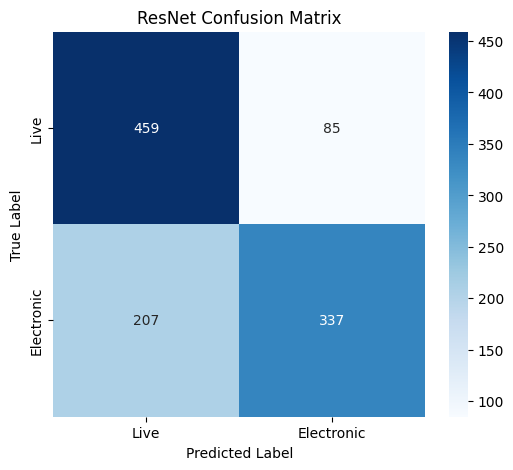

ResNet AUC-ROC Curve:


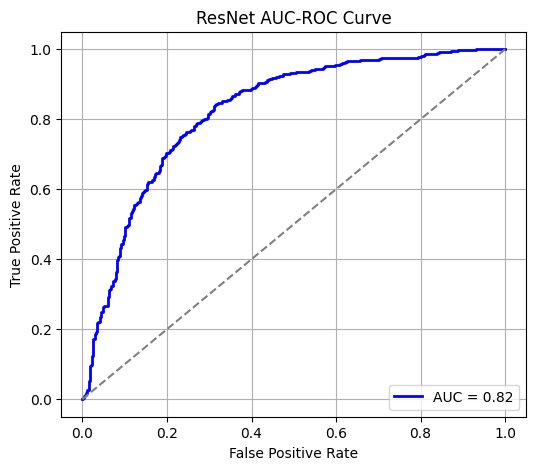

LightGBM Confusion Matrix:


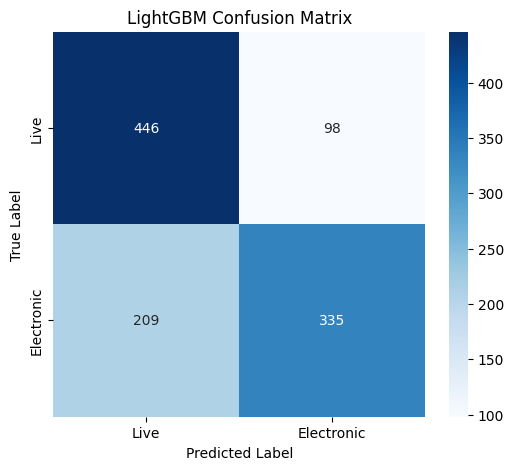

LightGBM AUC-ROC Curve:


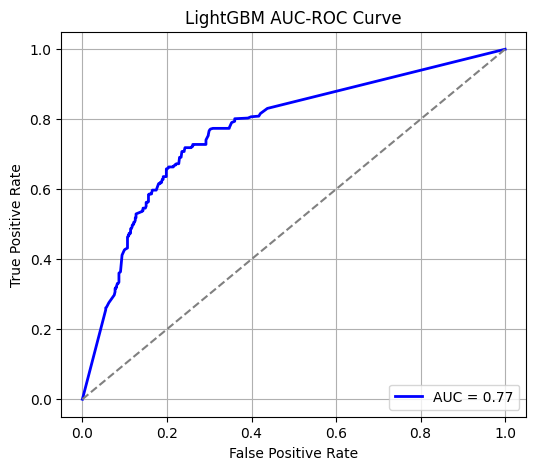

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Live", "Electronic"], yticklabels=["Live", "Electronic"])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Function to plot AUC-ROC curve
def plot_auc_roc(y_true, y_probs, title):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# ResNet Confusion Matrix and AUC-ROC
print("ResNet Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_binary_resnet, title="ResNet Confusion Matrix")
print("ResNet AUC-ROC Curve:")
plot_auc_roc(y_test, y_pred_probs_resnet, title="ResNet AUC-ROC Curve")

# LightGBM Confusion Matrix and AUC-ROC
print("LightGBM Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_binary_lgbm, title="LightGBM Confusion Matrix")
print("LightGBM AUC-ROC Curve:")
plot_auc_roc(y_test, y_pred_probs_lgbm, title="LightGBM AUC-ROC Curve")
